In [1]:
import numpy as np
from simplelandscape import (
    flat_energy, linear_energy, logistic_energy, quadratic_energy,
    umbrella_bias, OneDimLandscape)
from remd import RemdLadder
import adapt
from matplotlib import pyplot as pp
%matplotlib inline
%load_ext line_profiler

In [2]:
n_cond = 5
bias_x = np.linspace(450, 550, n_cond, dtype=int)

walkers = []
for x in bias_x:
    p = np.array((x, 0.025))
    w = OneDimLandscape(logistic_energy, umbrella_bias, x, p)
    walkers.append(w)

r = RemdLadder(walkers)

In [3]:
n_steps = 5000
coords = np.zeros((n_steps, n_cond))
for i in range(n_steps):
    r.update()
    x = np.array([w.x for w in r.walkers])
    coords[i, :] = x

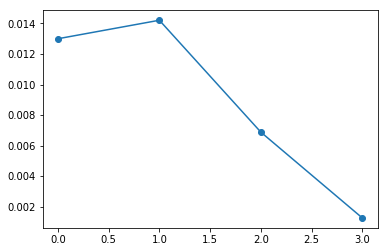

In [4]:
acc1 = r.acceptance.copy()
a1 = np.product(acc1)
pp.plot(acc1, marker='o')
#pp.ylim(0, 1)


In [5]:
lr = adapt.LearningRateDecay(np.array((1, 1e-9)), 5e-4)
m = adapt.MomentumSGD(0.99, adapt.compute_derivative_log_total_acc, lr)
# lr = adapt.LearningRateDecay(np.array((20, 1e-3)), 1e-2)
# m = adapt.Adam(0.9, 0.999, adapt.compute_derivative_log_total_acc, lr)
a = adapt.Adaptor(r, 8, m)

In [6]:
a.run(10000)

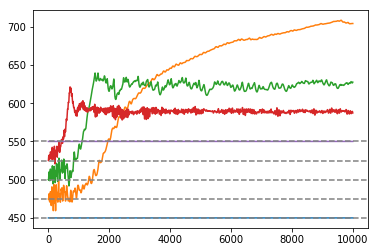

In [7]:
params = np.array(a.params)
pp.plot(params[:, :, 0])
pp.axhline(450, color='grey', linestyle='--')
pp.axhline(475, color='grey', linestyle='--')
pp.axhline(500, color='grey', linestyle='--')
pp.axhline(525, color='grey', linestyle='--')
pp.axhline(550, color='grey', linestyle='--');

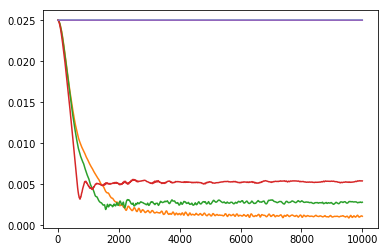

In [8]:
pp.plot(params[:, :, 1])
#pp.ylim(0, 0.004);

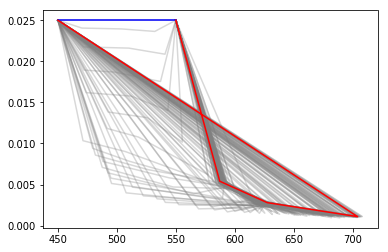

In [9]:
q = np.transpose(params, (1, 2, 0))
pp.plot(q[:, 0, ::100], q[:, 1, ::100], color='grey', alpha=0.3)
pp.plot(q[:, 0, 0], q[:, 1, 0], color='blue')
pp.plot(q[:, 0, -1], q[:, 1, -1], color='red');

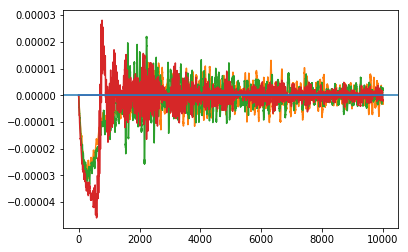

In [14]:
derivs = np.array(m.derivs)
pp.plot(derivs[:, :, 1])
pp.axhline(0);

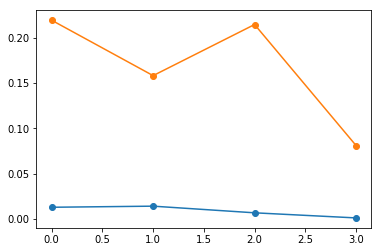

In [11]:
for i in range(n_steps):
    r.update()

acc2 = r.acceptance.copy()
a2 = np.product(acc2)
pp.plot(acc1, marker='o')
pp.plot(acc2, marker='o')
#pp.ylim(0, 1)

In [12]:
print a1, a2, a2 / a1

1.5970438564e-09 0.000602110559837 377015.670185


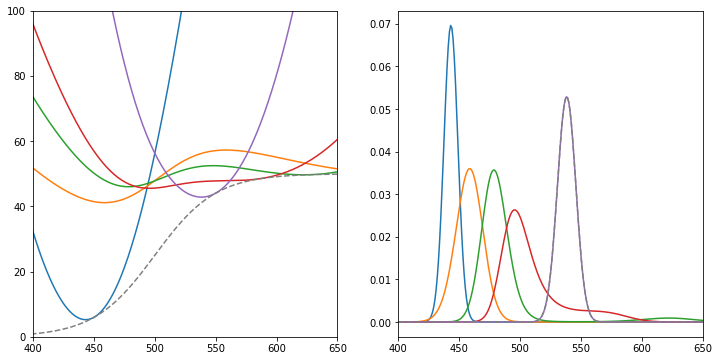

In [13]:
pp.figure(figsize=(12,6))

xs = np.array(range(1000))
y1 = logistic_energy(xs)
for i in range(n_cond):
    pp.subplot(1, 2, 1)
    parms = params[-1, i, :]
    y2 = umbrella_bias(xs, parms)[:, 0]
    y = y1 + y2
    pp.plot(xs, y)
    
    pp.subplot(1, 2, 2)
    p = np.exp(-y)
    p /= np.sum(p)
    pp.plot(xs, p)

pp.subplot(1, 2, 1)
pp.plot(xs, y1, color='grey', linestyle='--')
pp.ylim(0, 100)
pp.xlim(400, 650);

pp.subplot(1, 2, 2)
pp.plot(xs, p, color='grey', linestyle='--')
pp.xlim(400, 650);